## Train a convolutional neural network model 

Training a Resnet18 model that can distinguish between cats and dogs images.

Training set contains 250 cat and 250 dog images, under *img/train/cats* and *img/train/dogs*. Validation set contains 50 cat and 50 dog images, under *img/val/cats* and *img/val/dogs*.

Import all necessary libraries

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchtext import data
import os
import copy
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score
from sklearn.metrics.cluster import contingency_matrix
import random
import warnings 
warnings.filterwarnings('ignore')

###  Data Loading and Transformation

Tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data

1. Create data transformations for image augmentation and normalization in training and validation set. A list of built-in transformation can be found here: https://pytorch.org/docs/stable/torchvision/transforms.html.
Remember that Resnet18 takes an input size of 224x224.

In [2]:
data_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

2. Using *datasets.ImageFolder* under *torchvision*, load the training and validation datasets from *img* folder, and apply the transformations you created in 1.1 on each dataset.

In [3]:
data_dir = 'img/'
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(data_dir,x),
                                                     data_transforms[x])
                 for x in ['train','val']}

3. Create dataloaders for training and validation dataset using *torch.utils.data.DataLoader*.

In [4]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],batch_size=64,
                                             shuffle=True,num_workers=8)
              for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

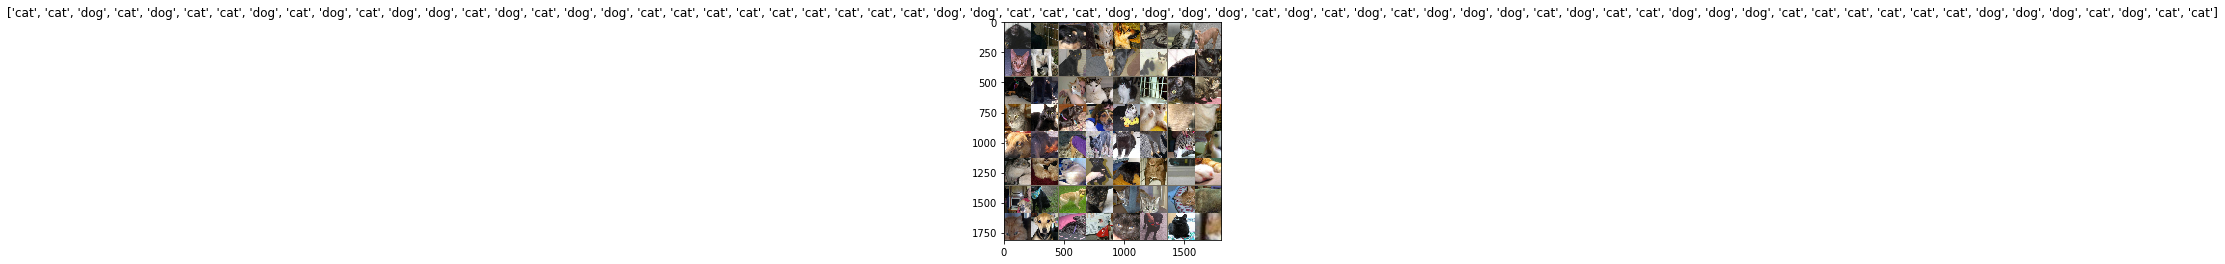

In [5]:
def imshow(inp,title=None):
    '''
    Imshow for Tensor
    '''
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    inp = std*inp+mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
# Get a batch of training data
inputs,classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out,title=[class_names[x] for x in classes])

###  Define loss function and optimizer

Define a loss function and optimizer that fulfill the following: (tutorial - https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-loss-function-and-optimizer)

List of built-in loss functions: https://pytorch.org/docs/stable/nn.html#loss-functions

Optimizers: https://pytorch.org/docs/stable/optim.html#algorithms

1. using cross entropy loss

2. using Adam optimizer

In [102]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam

###  Train Resnet18 from scratch

Tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

1. Initialize a Resnet18 model (not pre-trained) and change the size of output layer to 2 (the default model is a 1000-class multi-classification, while we have binary classes).

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
model_f = models.resnet18(pretrained=False)

num_ftrs = model_f.fc.in_features
model_f.fc = nn.Linear(num_ftrs,2)

model_f = model_f.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_f = optim.Adam(model_f.parameters(),lr=0.001,weight_decay=1e-4)

# decay the learning rate by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_f, step_size=10, gamma=0.1)

2. Train the model for a maximum of 50 epochs. Record the training loss at each epoch. Test the model performance on the validation set at each epoch and record the validation loss. You can tune several hyperparameters including batch size, learning rate, weight decay, etc. to improve the model's performance. Report the training and validation loss every 10 epochs and plot the overall training and validation loss curves.

In [8]:
tv_loss_f = []

def train_model(model,criterion,optimizer,scheduler,num_epochs=50):
    since=time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*10)
        
        # each epoch has training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.forward(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            tv_loss_f.append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} loss: {:.4f} acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Val Acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [9]:
model_f = train_model(model_f,criterion,optimizer_f,exp_lr_scheduler,
                     num_epochs = 50)

Epoch 0/49
----------
train loss: 1.3111 acc: 0.5000
val loss: 12.6222 acc: 0.5000

Epoch 1/49
----------
train loss: 0.7281 acc: 0.5460
val loss: 1.3730 acc: 0.5100

Epoch 2/49
----------
train loss: 0.7050 acc: 0.5720
val loss: 0.7782 acc: 0.5300

Epoch 3/49
----------
train loss: 0.6245 acc: 0.6580
val loss: 0.7197 acc: 0.5300

Epoch 4/49
----------
train loss: 0.6400 acc: 0.6500
val loss: 0.7627 acc: 0.5100

Epoch 5/49
----------
train loss: 0.6426 acc: 0.6260
val loss: 0.7424 acc: 0.5400

Epoch 6/49
----------
train loss: 0.6164 acc: 0.6680
val loss: 0.8630 acc: 0.4800

Epoch 7/49
----------
train loss: 0.6020 acc: 0.6580
val loss: 0.7504 acc: 0.5300

Epoch 8/49
----------
train loss: 0.6052 acc: 0.6740
val loss: 0.7811 acc: 0.5500

Epoch 9/49
----------
train loss: 0.6140 acc: 0.6700
val loss: 0.7188 acc: 0.6000

Epoch 10/49
----------
train loss: 0.5806 acc: 0.6880
val loss: 0.7159 acc: 0.5600

Epoch 11/49
----------
train loss: 0.5573 acc: 0.7220
val loss: 0.7249 acc: 0.5500

E

At the 10th epoch, the training loss is 0.6140 and the validation loss is 0.7188.

At the 20th epoch, the training loss is 0.5126 and the validation loss is 0.7154.

At the 30th epoch, the training loss is 0.4903 and the validation loss is 0.6906.

At the 40th epoch, the training loss is 0.4881 and the validation loss is 0.7033.

At the 50th epoch, the training loss is 0.5039 and the validation loss is 0.6993.

In [10]:
tv_loss_f = pd.DataFrame(tv_loss_f)
train_loss_f = tv_loss_f.iloc[::2] #even
val_loss_f = tv_loss_f.iloc[1::2] #odd

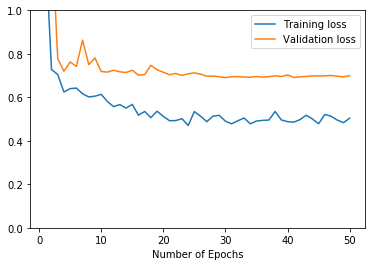

In [11]:
plt.plot(range(1,51),train_loss_f,label='Training loss')
plt.plot(range(1,51),val_loss_f,label='Validation loss')
plt.xlabel('Number of Epochs')
plt.ylim(0,1)
plt.legend()
plt.show()

In [12]:
y_pred = []
y_true = []

model_f.eval()

with torch.no_grad():
    for inputs,labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_f.forward(inputs)
        _,predicted = torch.max(outputs, 1)
        pred = predicted.numpy()
        lab = labels.numpy()
        y_pred.append(pred)
        y_true.append(lab)

In [13]:
y_true

[array([1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1],
       dtype=int64),
 array([1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1], dtype=int64)]

In [14]:
y_true_f = np.concatenate((y_true),axis=0)
y_true_f

array([1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1], dtype=int64)

In [15]:
y_pred

[array([1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1],
       dtype=int64),
 array([1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0], dtype=int64)]

In [16]:
y_pred_f = np.concatenate((y_pred),axis=0)
y_pred_f

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0], dtype=int64)

3. Report the contigency table, and calculate the overall accuracy, precision, recall, and F1 score of your optimized results.

In [17]:
print('Contingency matrix:\n', contingency_matrix(y_true_f,y_pred_f))
print('Accuracy:',accuracy_score(y_true_f,y_pred_f))
print('Precision:',precision_score(y_true_f,y_pred_f))
print('Recall:',recall_score(y_true_f,y_pred_f))
print('F1 score:',f1_score(y_true_f,y_pred_f))

Contingency matrix:
 [[22 28]
 [10 40]]
Accuracy: 0.62
Precision: 0.5882352941176471
Recall: 0.8
F1 score: 0.6779661016949153


### Transfer learning: pre-trained Resnet18 on ImageNet

Tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

1. Load a Resnet18 model pre-trained on ImageNet dataset. You can do this by specifying **pretrained=True**. Make sure to change the output size to 2.

In [19]:
model_t = models.resnet18(pretrained=True)

for param in model_t.parameters():
    param.requires_grad = False

num_ftrs = model_t.fc.in_features
model_t.fc = nn.Linear(num_ftrs,2)

model_t = model_t.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_t = optim.Adam(model_t.parameters(),lr=0.001,weight_decay=1e-4)

# decay learning rate by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_t, step_size=10, gamma=0.1)

2. Train the model for a maximum of 20 epochs. Record the training loss at each epoch. Test the model performance on the validation set at each epoch and record the validation loss. Tune the hyperparameters to improve the model's performance. Plot the overall training and validation loss curves, and report the contigency table, and calculate the overall accuracy, precision, recall, and F1 score of your optimized results.

In [20]:
tv_loss_t = []

def train_model(model,criterion,optimizer,scheduler,num_epochs=20):
    since=time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*10)
        
        # each epoch has training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.forward(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            tv_loss_t.append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} loss: {:.4f} acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Val Acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [21]:
model_t = train_model(model_t,criterion,optimizer_t,exp_lr_scheduler,
                     num_epochs = 20)

Epoch 0/19
----------
train loss: 0.5617 acc: 0.7120
val loss: 0.3687 acc: 0.9200

Epoch 1/19
----------
train loss: 0.3825 acc: 0.8680
val loss: 0.2355 acc: 0.9500

Epoch 2/19
----------
train loss: 0.2964 acc: 0.9060
val loss: 0.1633 acc: 0.9700

Epoch 3/19
----------
train loss: 0.2738 acc: 0.9040
val loss: 0.1354 acc: 0.9600

Epoch 4/19
----------
train loss: 0.2390 acc: 0.9140
val loss: 0.1156 acc: 0.9700

Epoch 5/19
----------
train loss: 0.2343 acc: 0.9220
val loss: 0.1164 acc: 0.9600

Epoch 6/19
----------
train loss: 0.2077 acc: 0.9260
val loss: 0.0989 acc: 0.9700

Epoch 7/19
----------
train loss: 0.1860 acc: 0.9400
val loss: 0.1028 acc: 0.9600

Epoch 8/19
----------
train loss: 0.2062 acc: 0.9200
val loss: 0.0907 acc: 0.9700

Epoch 9/19
----------
train loss: 0.1821 acc: 0.9320
val loss: 0.0876 acc: 0.9700

Epoch 10/19
----------
train loss: 0.1768 acc: 0.9440
val loss: 0.0885 acc: 0.9700

Epoch 11/19
----------
train loss: 0.1646 acc: 0.9420
val loss: 0.0877 acc: 0.9700

Ep

In [22]:
tv_loss_t = pd.DataFrame(tv_loss_t)
train_loss_t = tv_loss_t.iloc[::2] #even
val_loss_t = tv_loss_t.iloc[1::2] #odd

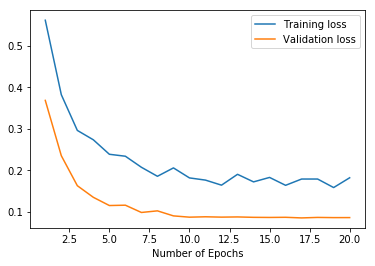

In [23]:
plt.plot(range(1,21),train_loss_t,label='Training loss')
plt.plot(range(1,21),val_loss_t,label='Validation loss')
plt.xlabel('Number of Epochs')
plt.legend()
plt.show()

In [24]:
y_pred = []
y_true = []

model_t.eval()

with torch.no_grad():
    for inputs,labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_t.forward(inputs)
        _,predicted = torch.max(outputs, 1)
        pred = predicted.numpy()
        lab = labels.numpy()
        y_pred.append(pred)
        y_true.append(lab)

In [26]:
y_true_t = np.concatenate((y_true),axis=0)
y_true_t

array([0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0], dtype=int64)

In [28]:
y_pred_t = np.concatenate((y_pred),axis=0)
y_pred_t

array([0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0], dtype=int64)

In [29]:
print('Contingency table:\n', contingency_matrix(y_true_t,y_pred_t))
print('Accuracy:',accuracy_score(y_true_t,y_pred_t))
print('Precision:',precision_score(y_true_t,y_pred_t))
print('Recall:',recall_score(y_true_t,y_pred_t))
print('F1 score:',f1_score(y_true_t,y_pred_t))

Contingency table:
 [[48  2]
 [ 1 49]]
Accuracy: 0.97
Precision: 0.9607843137254902
Recall: 0.98
F1 score: 0.9702970297029702


3. How is the training on the pre-trained model different from the non pre-trained model?

The training on the pre-trained model is different from the non pre-trained model because I specified `pretrained = False` for the non pre-trained model and `pretrained = True` for the pre-trained model as well as doing this for the pre-trained model:

>`for param in model_t.parameters():
      param.requires_grad = False`

Additionally, training on the pre-trained model reported lower loss and higher accuracy compared to the training on the non pre-trained model which had a higher loss and lower accuracy.

## Train a Long-Short Term Memory Neural Network (LSTM)

Using the Yelp dataset, which has 500 positive and 500 negative reviews, design a neural network architecture to detect sentiment in text. You are free to use any packages (pytorch, keras, tensorflow).

Tutorial (Upgraded Sentiment Analysis): https://github.com/bentrevett/pytorch-sentiment-analysis

1. Give a short description of your approach, including training/validation/testing split, overall architecture, word embeddings. This should also include the choice of optimizer and loss functions.

I will be using PyTorch's torchtext module to train a Long-Short Term Memoery (LSTM) neural network to detect sentiment in text. I will split the data into training and testing and then split the training into training and validation. I will preprocess  and tokenize the text/review data. My overall architecture will consist of a Embedding layer and a Bidirectional LSTM layer with Dropout. My choice of optimizer is Adam and my loss function is binary_crossentropy.

2. Train a model, and return your results on a held-out test set. This should include a training/validation error graph.

In [5]:
SEED = 421
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
TEXT = data.Field(tokenize='moses')
LABEL = data.LabelField(dtype=torch.float)
BATCH_SIZE = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Architecture
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, 
                           dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        output, (hidden, cell) = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden.squeeze(0))

In [8]:
pos = data.TabularDataset(path='yelp_labelled.txt', format='csv',
                          csv_reader_params={'delimiter':"\t"},
                          fields=[('text', TEXT), ('label', LABEL)])

#Of 1000 posts, 90/10 training/test
trainandval, test_data = pos.split(split_ratio=0.90,random_state=random.seed(421))
#Of the remaining training data, 80/20 train/validation
train_data, valid_data = trainandval.split(split_ratio=0.80,random_state=random.seed(421))

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data),
                                                batch_size=BATCH_SIZE,sort_key=lambda x: len(x.text),
                                                device=device)

In [9]:
#Maximum vocabulary, choose word vectors
TEXT.build_vocab(train_data,max_size=750, vectors="glove.twitter.27B.100d")
LABEL.build_vocab(train_data)
#Network Hyperparameters
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.925

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)

.vector_cache\glove.twitter.27B.zip: 1.52GB [11:56, 2.12MB/s]                                                          
100%|████████████████████████████████████████████████████████████████████▉| 1192988/1193514 [02:01<00:00, 10736.86it/s]

In [10]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)
optimizer = optim.Adam(model.parameters(),lr = 0.001)

criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum()/len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [11]:
N_EPOCHS=20
bestmodelvalue=0
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    if valid_acc >= bestmodelvalue:
        torch.save(model.state_dict(), "yelp_model.pt")
        bestmodelvalue=valid_acc
    print(f'Epoch: {epoch+1:02} | Train Acc: {train_acc*100:.2f}% Val. Acc: {valid_acc*100:.2f}%')

100%|████████████████████████████████████████████████████████████████████▉| 1192988/1193514 [02:20<00:00, 10736.86it/s]

Epoch: 01 | Train Acc: 52.72% Val. Acc: 48.85%
Epoch: 02 | Train Acc: 53.80% Val. Acc: 56.46%
Epoch: 03 | Train Acc: 48.64% Val. Acc: 48.85%
Epoch: 04 | Train Acc: 50.41% Val. Acc: 52.50%
Epoch: 05 | Train Acc: 52.58% Val. Acc: 53.54%
Epoch: 06 | Train Acc: 49.32% Val. Acc: 58.23%
Epoch: 07 | Train Acc: 49.73% Val. Acc: 62.40%
Epoch: 08 | Train Acc: 50.95% Val. Acc: 57.08%
Epoch: 09 | Train Acc: 52.85% Val. Acc: 60.00%
Epoch: 10 | Train Acc: 52.99% Val. Acc: 61.98%
Epoch: 11 | Train Acc: 57.47% Val. Acc: 65.00%
Epoch: 12 | Train Acc: 55.16% Val. Acc: 69.79%
Epoch: 13 | Train Acc: 56.52% Val. Acc: 71.35%
Epoch: 14 | Train Acc: 57.47% Val. Acc: 71.88%
Epoch: 15 | Train Acc: 61.55% Val. Acc: 75.83%
Epoch: 16 | Train Acc: 62.91% Val. Acc: 70.00%
Epoch: 17 | Train Acc: 60.19% Val. Acc: 68.44%
Epoch: 18 | Train Acc: 61.14% Val. Acc: 70.10%
Epoch: 19 | Train Acc: 64.27% Val. Acc: 72.40%
Epoch: 20 | Train Acc: 63.18% Val. Acc: 72.92%


In [12]:
model.load_state_dict(torch.load("yelp_model.pt"))
model.eval()
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print("Test Accuracy: ",test_acc)

Test Accuracy:  0.6953125


3. Describe your results.

My LSTM neural network for detecting sentiment in the Yelp reviews has an accuracy of 70%.